![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
MNIST_train.targets.shape

torch.Size([60000])

In [ ]:
MNIST_train.data.shape #в трейне 60к изображений 28х28

torch.Size([60000, 28, 28])

In [ ]:
MNIST_test.data.shape # в тесте 10к изображений 28х28

torch.Size([10000, 28, 28])

In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

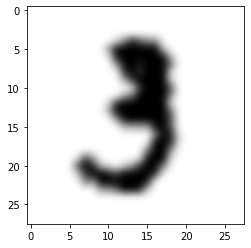

tensor(3)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10, :, :], cmap='binary', interpolation='bicubic')
plt.show()
print(y_train[10])

In [ ]:
X_train = X_train.unsqueeze(1).float() #добавляем измерение канала изображения (в нашем случае =1, т.к. черно-белое изображение)
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train[0].shape

torch.Size([1, 28, 28])

In [ ]:
from torch import nn
from torch.functional import F

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    #input = (размер батча,1,28,28)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2) 
    #(размер батча,6,28,28)
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
    #(размер батча,6,14,14)
    self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
    #(размер батча,16,10,10)
    self.pool2 = nn.AvgPool2d(kernel_size=2,stride=2)
    #(размер батча,16,5,5)
    # self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0)
    # #(размер батча,120,1,1)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120, bias=True)

    self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
    #(размер батча,84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = self.pool1(x)
    x = F.tanh(self.conv2(x))
    x = self.pool2(x)
    # x = F.tanh(self.conv3(x))
    # x = x.squeeze() #Убираем единицы в размерностях
    x = x.view(x.size(0), x.size(1)* x.size(2)*x.size(3))
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))

    return self.fc3(x)


In [ ]:
LeNet().forward(X_train[:20])[0] #результат работы для одной картинки

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([ 0.0362, -0.1102, -0.0418, -0.0448, -0.0717,  0.0994,  0.0163,  0.0706,
        -0.0043,  0.0752], grad_fn=<SelectBackward>)

In [ ]:
lenet5 = LeNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lenet5.parameters())

In [ ]:
criterion(LeNet().forward(X_train[:20]),y_train[:20]) #результат функции потерь для одного батча

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(2.3185, grad_fn=<NllLossBackward>)

In [ ]:
partition = {'train':[]}
labels = {}

for idx, p in enumerate(X_train):

  partition['train'].append(idx)
  labels[idx] = y_train[idx]

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
    self.list_IDs = list_IDs
    self.labels = labels

  def __len__(self):
    return len(self.list_IDs)

  def __getitem__(self, idx):
    ID = self.list_IDs[idx]
    
    X = X_train[ID] #загружаем данные - в другом варианте мы могли бы загружать их с диска
    y = self.labels[ID]
    
    return X, y


params = {'batch_size':100,
          'shuffle':True, 
          'num_workers':4}

train_iter = torch.utils.data.DataLoader(MyDataset(partition['train'], labels), **params)
# valid_iter = torch.utils.data.DataLoader(MyDataset(partition['valid'], labels), **params)


In [ ]:
#одна выгрузка даталоадера
print(next(iter(train_iter))[0].shape) # (размер батча, кол-во каналов, ширина, высота)
print(next(iter(train_iter))[1].shape) # метки таргета по размеру батча

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [ ]:
import warnings
warnings.filterwarnings('ignore')
epochs=500
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs_loss = []
epochs_accuracy = []
for epoch in range(epochs):
  
  if epoch % 10 == 0:
    print(epoch)
  for train_batch, train_labels in train_iter:

    train_batch, train_labels = train_batch.to(device), train_labels.to(device)

    optimizer.zero_grad()

    train_preds = lenet5.forward(train_batch)
    loss = criterion(train_preds, train_labels) #сначала предсказания, затем метки!!!
    loss.backward()
    optimizer.step()

  test_preds = lenet5.forward(X_test)
  test_loss = criterion(test_preds, y_test)
  test_acc = (test_preds.argmax(dim=1) == y_test).float().mean()
  epochs_loss.append(test_loss.data.cpu())
  epochs_accuracy.append(test_acc.data.cpu())



0
10
20
30
40
50
60
70
80
90
100
110


KeyboardInterrupt: ignored

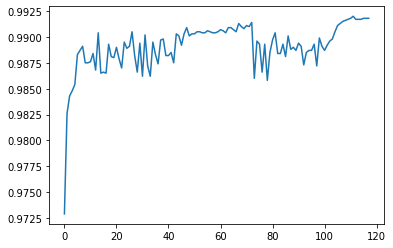

In [ ]:
plt.plot(np.arange(0,len(epochs_accuracy)),epochs_accuracy)


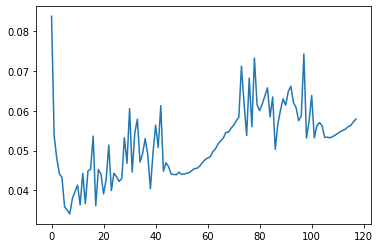

In [ ]:
plt.plot(np.arange(0,len(epochs_accuracy)),epochs_loss)